<a href="https://colab.research.google.com/github/Chaitanyaa/ML-CIFAR100/blob/master/Loop_Milestone3_CNN_model_Group_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Identifying superclasses indexes
# Identifying superclasses indexes
import pandas as pd
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded1 = drive.CreateFile({'id':'1IfioWuWPLvvMvkdVCflMh5v6xVfKwBxW'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('meta')

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
meta = unpickle('meta')
k=0
# Looping through the list to find the index of vehicle 1 and vehicle 2
for i in meta[b'coarse_label_names']:
  if i==b'vehicles_1':
    a = k
  if i==b'vehicles_2':
    b = k
  k=k+1  
print('Vehicle 1 index:',a,'\nVehicle 2 index:',b)
coarse = pd.DataFrame(meta[b'coarse_label_names'])
fine = pd.DataFrame(meta[b'fine_label_names'])

     |████████████████████████████████| 993kB 43.3MB/s 
Vehicle 1 index: 18 
Vehicle 2 index: 19


## With Cifar-100 dataset in Keras

In [0]:
# install keras first
!pip install dill
!pip install -q keras

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32,TF_CPP_MIN_LOG_LEVEL=2"

In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
#batch_size = 1000
num_classes = 2
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
from keras.datasets import cifar100

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [0]:
def combinedf(x,y,z):
  # Required subset of data in dataframe
  x = x.reshape(x.shape[0],3*32*32)
  images_df = pd.DataFrame(x, columns = list(range(0,3072)))
  temp = pd.DataFrame(y, columns = ['Target'])
  sub = pd.DataFrame(z, columns = ['Subtar'])
  images_df = pd.concat([images_df,sub,temp],axis=1)
  vehicle_images = images_df[(images_df['Target']==18) | (images_df['Target']==19) ]
  vehicle_images['Subtar'] = fine[0][vehicle_images['Subtar']].values # Subtar holds the subclass values.
  vehicle_images['Target'] = coarse[0][vehicle_images['Target']].values # Taget holds the superclass values
  #vehicle_images.head()
  return vehicle_images

In [0]:
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
(a_train, b_train), (a_test, b_test) = cifar100.load_data(label_mode='fine')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
trainset = combinedf(x_train,y_train,b_train)
testset  = combinedf(x_test,y_test,b_test)

169009152/169001437 [==============================] - 43s 0us/step
x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
data = pd.concat([trainset,testset],axis=0)

In [0]:
vehicle1 = np.unique(data[(data['Target']==b'vehicles_1')]['Subtar'])
vehicle1

array([b'bicycle', b'bus', b'motorcycle', b'pickup_truck', b'train'],
      dtype=object)

In [0]:
vehicle2 = np.unique(data[(data['Target']==b'vehicles_2')]['Subtar'])
vehicle2

array([b'lawn_mower', b'rocket', b'streetcar', b'tank', b'tractor'],
      dtype=object)

In [0]:
v1s1 = b'motorcycle'
v2s2 = b'lawn_mower'
v1s3 = b'pickup_truck'
v2s4 = b'streetcar'

In [0]:
trainset = data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2) & (data['Subtar']!=v1s3) & (data['Subtar']!=v2s4)) ]
testset = data[( (data['Subtar']==v1s1) | (data['Subtar']==v2s2) ) | (data['Subtar']==v1s3) | (data['Subtar']==v2s4) ]

In [0]:
data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2) & (data['Subtar']!=v1s3) & (data['Subtar']!=v2s4))].shape

(3600, 3074)

In [0]:
X_train = trainset.drop(['Subtar','Target'],axis=1)
y_train = trainset['Target']
X_test = testset.drop(['Subtar','Target'],axis=1)
y_test = testset['Target']

In [0]:
#Normalize data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [0]:
y_train = pd.get_dummies(y_train,drop_first=True)
y_test = pd.get_dummies(y_test,drop_first=True)

In [0]:
# def whiten(X):
#   # Assume input data matrix X of size [N x D]
#   X -= np.mean(X, axis = 0) # zero-center the data (important)
#   cov = np.dot(X.T, X) / X.shape[0] # get the data covariance matrix
#   U,S,V = np.linalg.svd(cov)
#   Xrot = np.dot(X, U)
#   Xrot_reduced = np.dot(X, U[:,:100]) # Xrot_reduced becomes [N x 100]
#   # whiten the data:
#   # divide by the eigenvalues (which are square roots of the singular values)
#   Xwhite = Xrot / np.sqrt(S + 1e-5)
#   return Xwhite
# X_train = whiten(X_train)
# X_test = whiten(X_test)

In [0]:
X_train.shape

(3600, 3072)

# CNN

In [0]:
from keras.utils import np_utils
# one hot encode outputs
y_train = to_categorical(y_train,num_classes=2)
y_test = to_categorical(y_test,num_classes=2)
num_classes = y_test.shape[1]

In [0]:
  X_train = X_train.values
  X_test = X_test.values

In [0]:
X_train = X_train.reshape(X_train.shape[0],3,32,32)
X_test = X_test.reshape(X_test.shape[0],3,32,32)

In [0]:
def build_model():
  model3=Sequential()

  model3.add(Conv2D(128, (3, 3), padding='same',input_shape=(3, 32, 32)))
  model3.add(Activation('relu'))
  model3.add(Conv2D(128, (3, 3)))
  model3.add(Activation('relu'))
  model3.add(MaxPooling2D(pool_size=(2, 2)))
  model3.add(Dropout(0.20))

  model3.add(Conv2D(256, (3, 3), padding='same'))
  model3.add(Activation('relu'))
  model3.add(Conv2D(256, (3, 3)))
  model3.add(Activation('relu'))
  model3.add(MaxPooling2D(pool_size=(2, 2)))
  model3.add(Dropout(0.25))

  model3.add(Conv2D(512, (3, 3), padding='same'))
  model3.add(Activation('relu'))
  model3.add(Conv2D(512, (3, 3)))
  model3.add(Activation('relu'))
  model3.add(MaxPooling2D(pool_size=(2, 2)))
  model3.add(Dropout(0.5))

  model3.add(Flatten())
  model3.add(Dense(1024))
  model3.add(Activation('relu'))
  model3.add(Dropout(0.5))
  model3.add(Dense(2))
  model3.add(Activation('softmax'))

  opt = Adam(lr=0.00005, decay=1e-6)
  model3.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

  opt = Adam(lr=0.00005, decay=1e-6)

  model3.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  #print('Using real-time data augmentation.')

  datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    rotation_range=0, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=False) 

  datagen.fit(X_train)
  #model3.summary()
  return model3,datagen


# Looping

In [0]:
 # Function for preparing the dataset
  def dataprep(v1s1,v1s2,v2s1,v2s2):
    trainset = data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v1s2) & (data['Subtar']!=v2s1) & (data['Subtar']!=v2s2)) ]
    testset = data[( (data['Subtar']==v1s1) | (data['Subtar']==v1s2) | (data['Subtar']==v2s1)|(data['Subtar']==v2s2))]
    X_train = trainset.drop(['Subtar','Target'],axis=1)
    y_train = trainset['Target']
    X_test = testset.drop(['Subtar','Target'],axis=1)
    y_test = testset['Target']
    #Normalize data
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255.0
    X_test /= 255.0
    y_train = pd.get_dummies(y_train,drop_first=True)
    y_test = pd.get_dummies(y_test,drop_first=True)
    return X_train,X_test,y_train,y_test

In [0]:
# Function for fitting the CNN model and saving the best epoch accuracy.
def cnn(H,X_train,X_test,y_train,y_test,datagen,model3):
  Best = str(H).replace("'","")
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  model_name = 'c_%s_m.{epoch:03d}.h5' % Best
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)
  # Prepare callbacks for model saving and for learning rate adjustment.
  checkpoint = ModelCheckpoint(filepath=filepath,
                               monitor='val_acc',
                               verbose=0,
                               save_best_only=True)
  callbacks = [checkpoint]
  
  
  #Let's train the model
  epochs = 30
  #batch_size=128
  Best = H
  hist = model3.fit_generator(datagen.flow(X_train, y_train,
      batch_size=128),shuffle= True,
      steps_per_epoch=X_train.shape[0] // 256,
      epochs=epochs,verbose=0,
      validation_data=(X_test, y_test),
      workers=4,callbacks=callbacks)
  
  # To load the most recent saved file for a particular combination => Highest accuracy epoch.
  var = !(ls saved_models -tr|tail -1)
  filenamestr = "/content/saved_models/"+var[0]
  model = load_model(filenamestr)
  scores = model.evaluate(X_test, y_test, verbose=0)
  print(H,"Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
# To avoid warnings in the output.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
# To avoid warnings in the output.
def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn

In [0]:
# Generating all 100 combinations and looping through each combination and calling below functions each time :
  # dataprep() -- // Seprates the data into train and test sets.
  # buildmodel() -- // Builds the CNN architecture
  # cnn() -- // Fits the model with train data
  # Takes around two and half hours to execute all combinations, save the best.
  # Prints the highest accuracy in each of 30 epochs for all combinations 
  
a = []
b = []
c = []
save_dir = os.path.join(os.getcwd(), 'saved_models')
from itertools import permutations 
perm1 = permutations(vehicle1, 2) 
perm2 = permutations(vehicle2, 2)
for i in list(perm1): 
    a+=[i]
for i in list(perm2): 
    b+=[i]    
    
skip=[]
for i in list(range(1,5)):
    m = 4*i
    for j in list(range(0,i)):
      skip += [m]
      m = m+1    

for i in sorted(skip, reverse=True): 
    del b[i]
    del a[i]
    
H=[]
for k in a:
    for l in b:
      v1s1 = k[0]
      v1s2 = k[1]
      v2s1 = l[0]
      v2s2 = l[1]
      os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
      tf.logging.set_verbosity(tf.logging.ERROR)
      X_train,X_test,y_train,y_test = dataprep(v1s1,v1s2,v2s1,v2s2)
      X_train = X_train.values
      X_test = X_test.values
      X_train = X_train.reshape(X_train.shape[0],3,32,32)
      X_test = X_test.reshape(X_test.shape[0],3,32,32)
      from keras.utils import np_utils
      # one hot encode outputs
      y_train = to_categorical(y_train,num_classes=2)
      y_test = to_categorical(y_test,num_classes=2)
      num_classes = y_test.shape[1]
      H+= [[[v1s1,v1s2],[v2s1,v2s2]]]
      #print(v1s1,v2s1,v1s2,v2s2)
      #print(y_train.shape)
      graph = tf.Graph()                  #Important piece of code to handle session reseting issue within the loop.
      with tf.Session(graph=graph):        
        model3,datagen = build_model()
        cnn([[[v1s1,v1s2],[v2s1,v2s2]]],X_train,X_test,y_train,y_test,datagen,model3)    

[[[b'bicycle', b'bus'], [b'lawn_mower', b'rocket']]] Accuracy: 55.42%


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3e8e424cf8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3e8e716278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

[[[b'bicycle', b'bus'], [b'lawn_mower', b'streetcar']]] Accuracy: 54.46%


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3e7be0ab38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3e7def5be0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

[[[b'bicycle', b'bus'], [b'lawn_mower', b'tank']]] Accuracy: 52.46%
[[[b'bicycle', b'bus'], [b'lawn_mower', b'tractor']]] Accuracy: 56.92%
[[[b'bicycle', b'bus'], [b'rocket', b'streetcar']]] Accuracy: 53.83%
[[[b'bicycle', b'bus'], [b'rocket', b'tank']]] Accuracy: 59.38%
[[[b'bicycle', b'bus'], [b'rocket', b'tractor']]] Accuracy: 56.12%


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d6ec65ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


[[[b'bicycle', b'bus'], [b'streetcar', b'tank']]] Accuracy: 50.00%


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d6fe81d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d6fe81dd8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

[[[b'bicycle', b'bus'], [b'streetcar', b'tractor']]] Accuracy: 52.04%
[[[b'bicycle', b'bus'], [b'tank', b'tractor']]] Accuracy: 52.42%
[[[b'bicycle', b'motorcycle'], [b'lawn_mower', b'rocket']]] Accuracy: 57.12%
[[[b'bicycle', b'motorcycle'], [b'lawn_mower', b'streetcar']]] Accuracy: 55.62%
[[[b'bicycle', b'motorcycle'], [b'lawn_mower', b'tank']]] Accuracy: 55.12%
[[[b'bicycle', b'motorcycle'], [b'lawn_mower', b'tractor']]] Accuracy: 57.50%
[[[b'bicycle', b'motorcycle'], [b'rocket', b'streetcar']]] Accuracy: 51.00%
[[[b'bicycle', b'motorcycle'], [b'rocket', b'tank']]] Accuracy: 56.88%
[[[b'bicycle', b'motorcycle'], [b'rocket', b'tractor']]] Accuracy: 53.29%
[[[b'bicycle', b'motorcycle'], [b'streetcar', b'tank']]] Accuracy: 50.00%
[[[b'bicycle', b'motorcycle'], [b'streetcar', b'tractor']]] Accuracy: 50.00%
[[[b'bicycle', b'motorcycle'], [b'tank', b'tractor']]] Accuracy: 50.00%
[[[b'bicycle', b'pickup_truck'], [b'lawn_mower', b'rocket']]] Accuracy: 60.96%
[[[b'bicycle', b'pickup_truck'],

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d513e9a58>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


[[[b'bicycle', b'pickup_truck'], [b'lawn_mower', b'tank']]] Accuracy: 59.88%
[[[b'bicycle', b'pickup_truck'], [b'lawn_mower', b'tractor']]] Accuracy: 63.21%
[[[b'bicycle', b'pickup_truck'], [b'rocket', b'streetcar']]] Accuracy: 55.04%
[[[b'bicycle', b'pickup_truck'], [b'rocket', b'tank']]] Accuracy: 58.96%


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d520539b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d52053438>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

[[[b'bicycle', b'pickup_truck'], [b'rocket', b'tractor']]] Accuracy: 57.50%
[[[b'bicycle', b'pickup_truck'], [b'streetcar', b'tank']]] Accuracy: 49.96%
[[[b'bicycle', b'pickup_truck'], [b'streetcar', b'tractor']]] Accuracy: 50.00%
[[[b'bicycle', b'pickup_truck'], [b'tank', b'tractor']]] Accuracy: 50.29%
[[[b'bicycle', b'train'], [b'lawn_mower', b'rocket']]] Accuracy: 49.54%
[[[b'bicycle', b'train'], [b'lawn_mower', b'streetcar']]] Accuracy: 52.04%
[[[b'bicycle', b'train'], [b'lawn_mower', b'tank']]] Accuracy: 52.62%
[[[b'bicycle', b'train'], [b'lawn_mower', b'tractor']]] Accuracy: 54.83%
[[[b'bicycle', b'train'], [b'rocket', b'streetcar']]] Accuracy: 50.00%
[[[b'bicycle', b'train'], [b'rocket', b'tank']]] Accuracy: 55.08%
[[[b'bicycle', b'train'], [b'rocket', b'tractor']]] Accuracy: 56.54%
[[[b'bicycle', b'train'], [b'streetcar', b'tank']]] Accuracy: 50.04%
[[[b'bicycle', b'train'], [b'streetcar', b'tractor']]] Accuracy: 50.00%
[[[b'bicycle', b'train'], [b'tank', b'tractor']]] Accuracy

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d2343e9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


[[[b'bus', b'motorcycle'], [b'rocket', b'tank']]] Accuracy: 56.12%
[[[b'bus', b'motorcycle'], [b'rocket', b'tractor']]] Accuracy: 58.54%
[[[b'bus', b'motorcycle'], [b'streetcar', b'tank']]] Accuracy: 53.79%
[[[b'bus', b'motorcycle'], [b'streetcar', b'tractor']]] Accuracy: 55.50%
[[[b'bus', b'motorcycle'], [b'tank', b'tractor']]] Accuracy: 55.04%
[[[b'bus', b'pickup_truck'], [b'lawn_mower', b'rocket']]] Accuracy: 49.92%
[[[b'bus', b'pickup_truck'], [b'lawn_mower', b'streetcar']]] Accuracy: 59.46%
[[[b'bus', b'pickup_truck'], [b'lawn_mower', b'tank']]] Accuracy: 56.38%


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d2412a240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3d2412a358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/

[[[b'bus', b'pickup_truck'], [b'lawn_mower', b'tractor']]] Accuracy: 53.83%
[[[b'bus', b'pickup_truck'], [b'rocket', b'streetcar']]] Accuracy: 52.12%
[[[b'bus', b'pickup_truck'], [b'rocket', b'tank']]] Accuracy: 50.88%
[[[b'bus', b'pickup_truck'], [b'rocket', b'tractor']]] Accuracy: 50.42%
[[[b'bus', b'pickup_truck'], [b'streetcar', b'tank']]] Accuracy: 51.29%
[[[b'bus', b'pickup_truck'], [b'streetcar', b'tractor']]] Accuracy: 51.62%
[[[b'bus', b'pickup_truck'], [b'tank', b'tractor']]] Accuracy: 50.00%
[[[b'bus', b'train'], [b'lawn_mower', b'rocket']]] Accuracy: 49.88%
[[[b'bus', b'train'], [b'lawn_mower', b'streetcar']]] Accuracy: 52.88%
[[[b'bus', b'train'], [b'lawn_mower', b'tank']]] Accuracy: 53.87%
[[[b'bus', b'train'], [b'lawn_mower', b'tractor']]] Accuracy: 56.96%
[[[b'bus', b'train'], [b'rocket', b'streetcar']]] Accuracy: 49.29%
[[[b'bus', b'train'], [b'rocket', b'tank']]] Accuracy: 52.88%
[[[b'bus', b'train'], [b'rocket', b'tractor']]] Accuracy: 53.87%
[[[b'bus', b'train'], [b

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3cc961d908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


[[[b'pickup_truck', b'train'], [b'lawn_mower', b'rocket']]] Accuracy: 50.00%
[[[b'pickup_truck', b'train'], [b'lawn_mower', b'streetcar']]] Accuracy: 52.92%
[[[b'pickup_truck', b'train'], [b'lawn_mower', b'tank']]] Accuracy: 57.04%
[[[b'pickup_truck', b'train'], [b'lawn_mower', b'tractor']]] Accuracy: 55.71%
[[[b'pickup_truck', b'train'], [b'rocket', b'streetcar']]] Accuracy: 47.92%
[[[b'pickup_truck', b'train'], [b'rocket', b'tank']]] Accuracy: 54.46%
[[[b'pickup_truck', b'train'], [b'rocket', b'tractor']]] Accuracy: 50.54%
[[[b'pickup_truck', b'train'], [b'streetcar', b'tank']]] Accuracy: 52.12%
[[[b'pickup_truck', b'train'], [b'streetcar', b'tractor']]] Accuracy: 50.96%
[[[b'pickup_truck', b'train'], [b'tank', b'tractor']]] Accuracy: 52.08%


## To identify the filename of the combination that got the highest accuracy.

#### Last saved file for a particular combination is the highest accuracy it got during its iteration.

In [0]:
## This list will be specific to this session only.
save_dir = os.path.join(os.getcwd(), 'saved_models')
!ls saved_models

'c_[[[bbicycle, bbus], [blawn_mower, brocket]]]_m.001.h5'
'c_[[[bbicycle, bbus], [blawn_mower, brocket]]]_m.003.h5'
'c_[[[bbicycle, bbus], [blawn_mower, brocket]]]_m.004.h5'
'c_[[[bbicycle, bbus], [blawn_mower, brocket]]]_m.008.h5'
'c_[[[bbicycle, bbus], [blawn_mower, brocket]]]_m.009.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.001.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.003.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.009.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.011.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.022.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.023.h5'
'c_[[[bbicycle, bbus], [blawn_mower, bstreetcar]]]_m.024.h5'
'c_[[[bbicycle, bbus], [blawn_mower, btank]]]_m.001.h5'
'c_[[[bbicycle, bbus], [blawn_mower, btank]]]_m.007.h5'
'c_[[[bbicycle, bbus], [blawn_mower, btank]]]_m.008.h5'
'c_[[[bbicycle, bbus], [blawn_mower, btank]]]_m.021.h5'
'c_[[[bbicycle, bbus], [blawn_mower, btank]]]_m.025.h5'
'c_

In [0]:
# #Let's train the model
# epochs = 30
# #batch_size=128
# hist = model3.fit_generator(datagen.flow(X_train, y_train,
#     batch_size=128),shuffle= True,
#     steps_per_epoch=X_train.shape[0] // 256,
#     epochs=epochs,
#     validation_data=(X_test, y_test),
#     workers=4,callbacks=callbacks)

In [0]:
scores = model3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
    
plot_model_history(hist)

In [0]:
y_test.shape

(2400, 2)

## Noted the combination for which the accuracy was highest and loading that model back.

#### Change X_test,y_test as per the required combination here.

In [0]:
### Look through the above outputs and make changes in this part of code cell.

bestmodel = load_model('/content/saved_models/c_[[[bmotorcycle, bpickup_truck], [blawn_mower, bstreetcar]]]_m.024.h5')
scores = bestmodel.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 68.38%


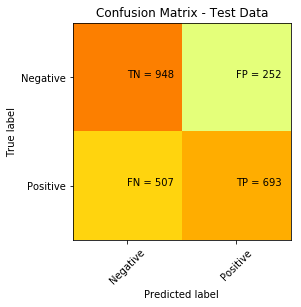

In [0]:
## Confusion matrix of the loaded model
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = bestmodel.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [0]:
## Classification report of the loaded model
from sklearn.metrics import classification_report
cp = classification_report(np.argmax(y_test,axis=1),y_pred)
print(cp)

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      1200
           1       0.73      0.58      0.65      1200

   micro avg       0.68      0.68      0.68      2400
   macro avg       0.69      0.68      0.68      2400
weighted avg       0.69      0.68      0.68      2400



In [0]:
#print out randomly selected images(black/red labl-->correct/wrong prediction )
def cifar_grid_c(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
#  clabels = labels["label_names"]
  clabels = ['vehicles 1','vehicles 2']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
     # axes[j][k].set_axis_off()
      if i_inds < N:
        rgb = X[[i_data,...]]
        #print(rgb.shape)
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        axes[j][k].imshow(img, interpolation='nearest')
        label = clabels[np.argmax(Y[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)

<class 'list'>


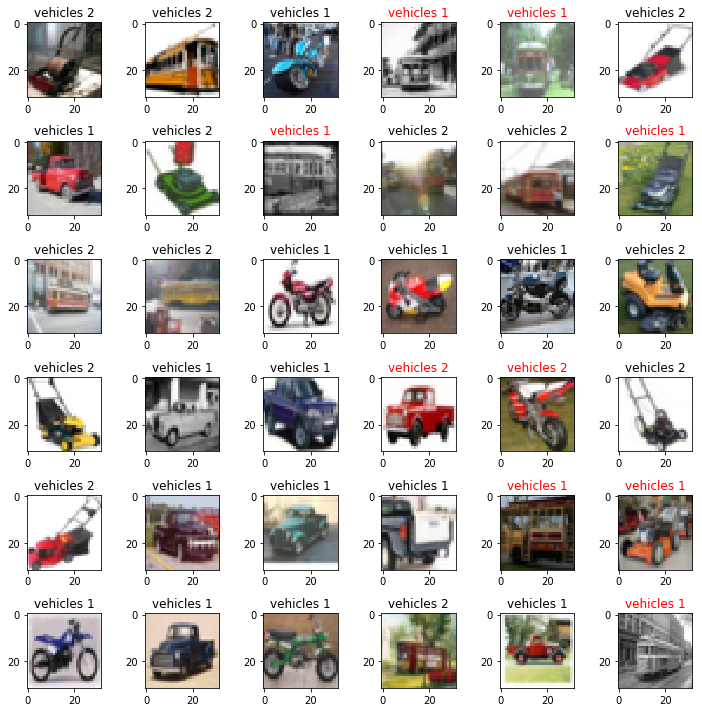

In [0]:
num_predictions = 36
predict_gen = bestmodel.predict_generator(datagen.flow(X_test, y_test,
    batch_size=256, shuffle=False),
    steps=(X_test.shape[0] // 256)+1, workers=4)

indices = [np.random.choice(range(len(X_test))) 
           for i in range(num_predictions)]

cifar_grid_c(X_test,y_test,indices,6, predictions=predict_gen)

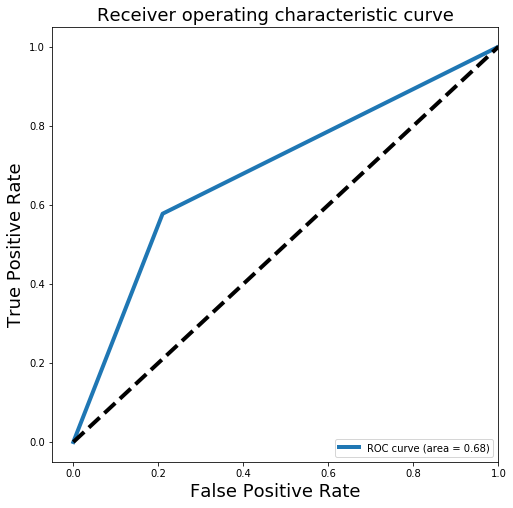

In [0]:
## ROC curve of the loaded model
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(np.argmax(y_test,axis=1),y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()